In [2]:
#classic env
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

#GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point

#DateTimeIndex
from datetime import datetime

#fix figsize
plt.rcParams["figure.figsize"]=16,9

#to print the entire pandas dataframe/series
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

#import original dataset
dataset = pd.read_csv('UA_mobility.csv', parse_dates=['date']).rename(columns = {'ID':'id'})

#create GeoDataFrame with detections as POINT(longitude, latidute)
points=dataset.apply(lambda row: Point(row.lon, row.lat), axis=1)
geo_dataset= gpd.GeoDataFrame(dataset, geometry=points, crs= 'EPSG:4326')

#delete duplicates and inconsistencies(keep the first detection in case of inconsistencies)
geo_dataset.drop_duplicates(subset=['id', 'date'], inplace=True, ignore_index=True)

#create GeoDataFrame with DateTimeIndex
geo_dataset.set_index('date', inplace=True)
geo_dataset.sort_index(inplace=True)
geo_dataset=geo_dataset[: "2022-12-31"]

#some info
number_of_detections=len(geo_dataset)
number_of_users=geo_dataset.id.nunique()
start_date=geo_dataset.index.min()
end_date=geo_dataset.index.max()
delta=end_date-start_date
number_of_days=len(geo_dataset.resample('D').geometry.count())
number_of_months=len(geo_dataset.resample('M').geometry.count())
number_of_years=len(geo_dataset.resample('Y').geometry.count())

#import ukraine's shapefile (GeoDataFrame) with regions's boundiaries
ukraine=gpd.read_file('shape/UKR_adm1.shp')

#fix invalid geometry
ukraine.geometry=ukraine.buffer(0)

#fix columns
ukraine.drop(columns=['ID_0','ISO','ID_1','HASC_1','CCN_1','CCA_1','TYPE_1','NL_NAME_1','VARNAME_1'], inplace=True)
ukraine.rename(columns = {'NAME_0':'state','NAME_1':'region', 'ENGTYPE_1':'type'}, inplace=True)

#some info
number_of_regions=ukraine.region.nunique()

#create a series of colors, one color for each region
palette = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FFA500", "#800080", "#008000", "#000080",
          "#800000", "#008080", "#808000", "#C0C0C0", "#808080", "#FF69B4", "#CD5C5C", "#F08080", "#FFD700", "#FF4500",
          "#8A2BE2", "#6A5ACD", "#20B2AA", "#32CD32", "#FF6347", "#FF8C00", "#00FF7F"]
colors = pd.Series(palette, index=ukraine.region)

#spatial-join based on geographic relationships between Point and Polygon
sjoin=gpd.sjoin(geo_dataset, ukraine, how='inner', predicate='within')
sjoin.drop(columns=['index_right'], inplace=True)
sjoin.sort_index(inplace=True)

#import extra informations about each region: total population and surface(km^2)
#source: wikipedia
data = {'total_population': [1277303, 1088509, 905264, 1963008, 3320299,
                              4403178, 1380128, 2742180, 1083367, 1320171,
                              1719558, 2814258, 1002420, 2540938, 2272676,
                              1178223, 2388297, 1477195, 1154256, 381234,
                              1152333, 1080431, 1250759, 1634187, 1038598,
                              1791668, 1273199],
        'surface': [20916, 31903, 8096, 26080, 31923,
                     26517, 13927, 31418, 28461, 20629,
                     28121, 836, 24588, 21831, 26683,
                     24585, 33313, 28750, 20051, 864,
                     23832, 13824, 12753, 26492, 20144,
                     27183, 29827]}

extra_data = pd.DataFrame(data, index=['Cherkasy', 'Chernihiv', 'Chernivtsi', 'Crimea', "Dnipropetrovs'k",
                                       "Donets'k", "Ivano-Frankivs'k",'Kharkiv', "Kherson", "Khmel'nyts'kyy",
                                       'Kiev', 'Kiev City', 'Kirovohrad', "L'viv", "Luhans'k",
                                       'Mykolayiv', 'Odessa', 'Poltava', 'Rivne', "Sevastopol'",
                                       'Sumy', "Ternopil'", 'Transcarpathia', 'Vinnytsya', 'Volyn',
                                       'Zaporizhzhya', 'Zhytomyr'])

#add new columns in ukraine's GeoDataFrame: 
#total_detections, different_users, total_population and surface(km^2) per region
ukraine.set_index('region', inplace=True)
ukraine['total_detections']=sjoin.region.value_counts().sort_index()
ukraine['different_users']=sjoin.groupby('region').id.nunique()
ukraine['total_population']=extra_data.total_population
ukraine['surface(km^2)']=extra_data.surface
ukraine.reset_index(inplace=True)

In [3]:
#function to calculate the total kilometers traveled given a GeoSeries of detection points
from geopy.distance import geodesic

def dist_function(points):
    points=points.sort_index()
    total_distance = 0
    for i in range(len(points) - 1):
        distance = geodesic((points[i].y, points[i].x), (points[i+1].y, points[i+1].x)).kilometers
        total_distance += distance
    return total_distance

In [4]:
#DAY, ID, REGION -> NUMBER OF KM PER DAY, ID, REGION 
#km calcolati tra punti temporalmente adiacenti, massimo 1 giorno di distanza.

regions=ukraine.region
ids= set(sjoin.id.values)
date = pd.date_range(start=start_date, end=end_date, freq='D', normalize=True)

multi_index = pd.MultiIndex.from_product([date, ids, regions], names=['date', 'id', 'region'])
km_final=pd.Series(0, index=multi_index)

from datetime import datetime, timedelta

def same_date(t1, t2):
    return (t1.year==t2.year and t1.month==t2.month and t1.day==t2.day)

def adiacent_date(t1, t2):
    datetime1 = pd.to_datetime(t1, unit='s')
    datetime2 = pd.to_datetime(t2, unit='s')
    next_day_datetime1 = datetime1 + timedelta(days=1)
    return datetime2.date() == next_day_datetime1.date()

def calculate_km_final(group):
    group=group.sort_index()
    for i in range(len(group)-1):
        date1=group.index[i]
        row1=group.iloc[i]
        date2=group.index[i+1]
        row2=group.iloc[i+1]
        distance=dist_function(gpd.GeoSeries([row1.geometry, row2.geometry]))
        if(row1.region==row2.region and same_date(date1, date2)):
            km_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=distance
            
        if(row1.region!=row2.region and same_date(date1, date2)):
            km_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=(distance/2)
            km_final["{}-{}-{}".format(date2.year, date2.month, date2.day), row2.id, row2.region]+=(distance/2) 
            
        if(row1.region==row2.region and not(same_date(date1, date2))):
            if(adiacent_date(date1, date2)):
                km_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=(distance/2)
                km_final["{}-{}-{}".format(date2.year, date2.month, date2.day), row2.id, row2.region]+=(distance/2)
      
        if(row1.region!=row2.region and not(same_date(date1, date2))):
            if(adiacent_date(date1, date2)):
                km_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=(distance/2)
                km_final["{}-{}-{}".format(date2.year, date2.month, date2.day), row2.id, row2.region]+=(distance/2)
                     
sjoin.groupby('id', group_keys=False).apply(calculate_km_final) 

km_final=km_final[:,:,'Kiev City'].groupby('date').sum()

In [5]:
#DAY, ID, REGION -> NUMBER OF DIFFERENT USER DETECTED PER DAY, ID, REGION 
#vengono presi in considerazione i rilevamenti in modo coerente con il calcolo della km_final series.

regions=ukraine.region
ids= set(sjoin.id.values)
date = pd.date_range(start=start_date, end=end_date, freq='D', normalize=True)

multi_index = pd.MultiIndex.from_product([date, ids, regions], names=['date', 'id', 'region'])
user_final=pd.Series(0, index=multi_index)

from datetime import datetime, timedelta

def same_date(t1, t2):
    return (t1.year==t2.year and t1.month==t2.month and t1.day==t2.day)

def adiacent_date(t1, t2):
    datetime1 = pd.to_datetime(t1, unit='s')
    datetime2 = pd.to_datetime(t2, unit='s')
    next_day_datetime1 = datetime1 + timedelta(days=1)
    return datetime2.date() == next_day_datetime1.date()

def calculate_user_final(group):
    group=group.sort_index()
    for i in range(len(group)-1):
        date1=group.index[i]
        row1=group.iloc[i]
        date2=group.index[i+1]
        row2=group.iloc[i+1]
        distance=dist_function(gpd.GeoSeries([row1.geometry, row2.geometry]))
        if(row1.region==row2.region and same_date(date1, date2)):
            user_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=1
            
        if(row1.region!=row2.region and same_date(date1, date2)):
            user_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=1
            user_final["{}-{}-{}".format(date2.year, date2.month, date2.day), row2.id, row2.region]+=1 
            
        if(row1.region==row2.region and not(same_date(date1, date2))):
            if(adiacent_date(date1, date2)):
                user_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=1
                user_final["{}-{}-{}".format(date2.year, date2.month, date2.day), row2.id, row2.region]+=1
       
        if(row1.region!=row2.region and not(same_date(date1, date2))):
            if(adiacent_date(date1, date2)):
                user_final["{}-{}-{}".format(date1.year, date1.month, date1.day), row1.id, row1.region]+=1
                user_final["{}-{}-{}".format(date2.year, date2.month, date2.day), row2.id, row2.region]+=1
                     
sjoin.groupby('id', group_keys=False).apply(calculate_user_final) 

def set_non_0_to_1(x):
    return 1 if x != 0 else x

user_final_for_kievcity=user_final.apply(set_non_0_to_1)[:,:,'Kiev City'].groupby('date').sum()

In [6]:
km=km_final.copy()
user=user_final_for_kievcity.copy()
series=km/user
series[series.isna()]=0

In [7]:
from scipy.signal import medfilt

#filtro mediano per ridurre il rumore (serie più smooth) mantenendo gli stessi indici della serie di partenza
filtered_series = pd.Series(medfilt(series.values, kernel_size=3), index=series.index)
dataset=filtered_series.copy()

dataset[dataset>=30]=30

small_amount = 0.0000000001
dataset += dataset.groupby(dataset).cumcount() * small_amount

dataset_for_rnn=dataset[:"2022-01-8"]
dataset_for_anomaly=dataset["2022-01-9":]

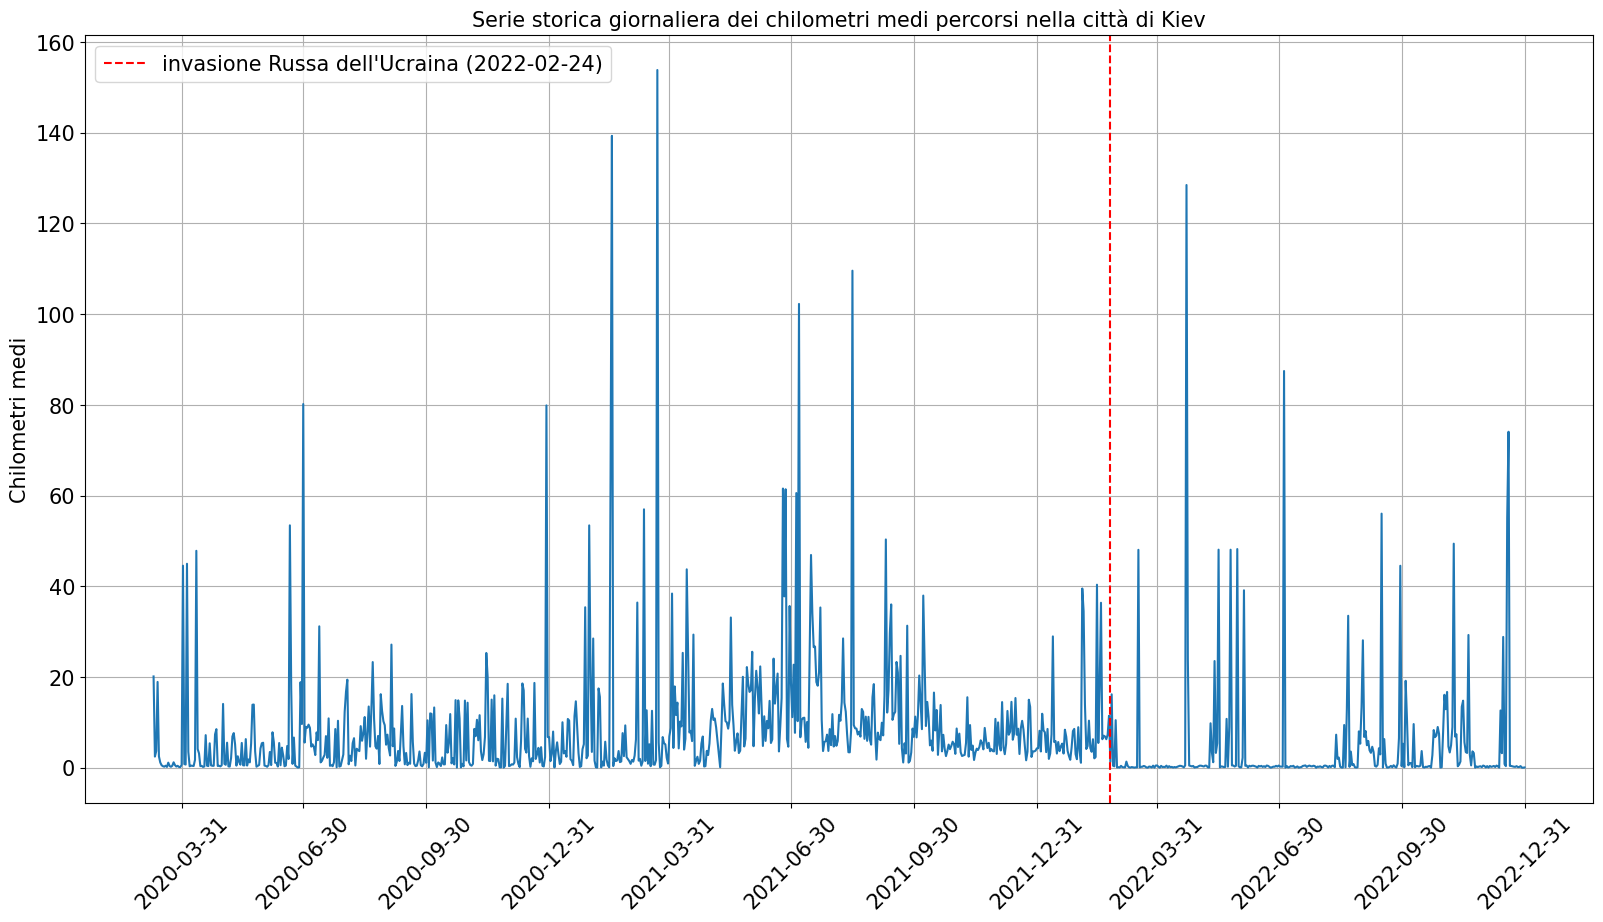

In [8]:
#GRAPHIC -> Serie storica giornaliera del numero di KM percorsi/differenti utenti rilevati a Kiev City

prova1=series.copy()
view=prova1

valori_casuali = np.random.uniform(0, 0.5, len(prova1[prova1==0]))
(prova1[prova1==0]) = valori_casuali

data=view
dates=data.index
values=data.values
plt.plot_date(dates, values, linestyle='solid', markersize=0)  
    
#russian invasion of ukraine
plt.axvline(x=datetime(2022, 2, 24), color='r', linestyle='--', label="invasione Russa dell'Ucraina (2022-02-24)")
#plt.axvline(x=datetime(2020, 3, 10), color='y')
#plt.axvline(x=datetime(2022, 1, 9), color='y')

xticks=pd.date_range(start=start_date, end=end_date, freq='3M', normalize=True)
plt.xticks(xticks, rotation=45)  


plt.title('Serie storica giornaliera dei chilometri medi percorsi nella città di Kiev', fontsize=15)
plt.ylabel('Chilometri medi', fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.grid(True)
plt.tight_layout()

plt.tick_params(axis='both', labelsize=15)
plt.show()

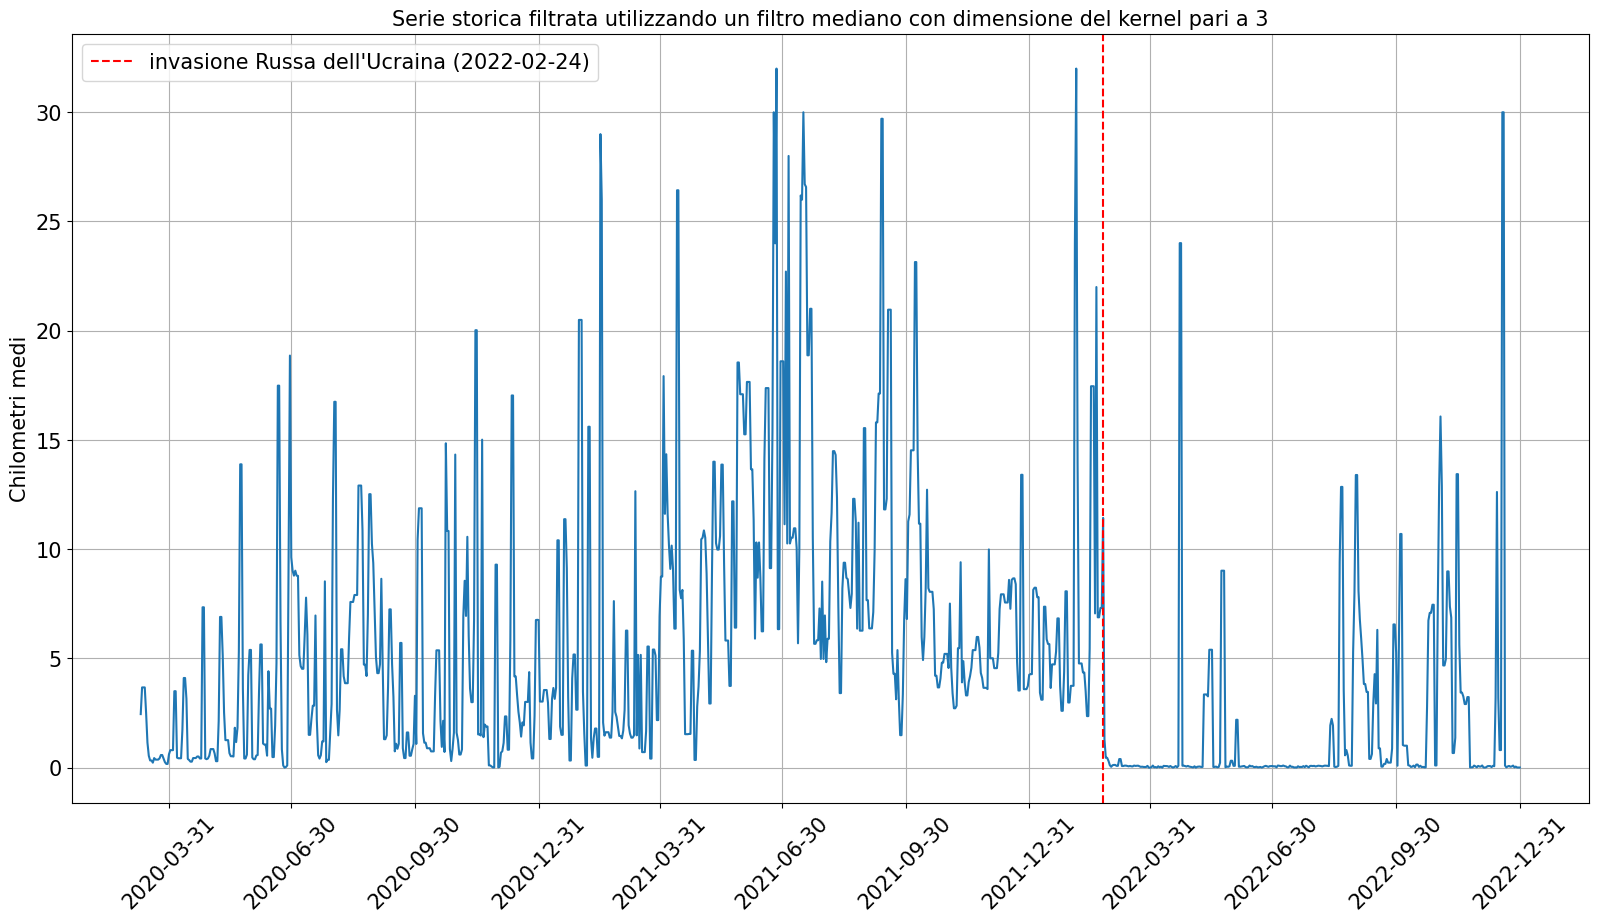

In [9]:
#GRAPHIC -> Serie storica giornaliera del numero di KM percorsi/differenti utenti rilevati a Kiev City

prova=dataset.copy()
prova["2021-02-15"]=29
prova["2021-02-16"]=26
prova["2021-06-25"]=24
prova["2021-06-26"]=32
prova["2021-07-05"]=28
prova["2021-07-15"]=26
prova["2022-02-03"]=24
prova["2022-02-04"]=32
prova["2022-02-19"]=22


valori_casuali = np.random.uniform(0, 0.1, len(prova[prova<0.001]))
(prova[prova<0.001]) = valori_casuali

view=prova

data=view
dates=data.index
values=data.values
plt.plot_date(dates, values, linestyle='solid', markersize=0)  
    
#russian invasion of ukraine
plt.axvline(x=datetime(2022, 2, 24), color='r', linestyle='--', label="invasione Russa dell'Ucraina (2022-02-24)")
#plt.axvline(x=datetime(2020, 3, 10), color='y')
#plt.axvline(x=datetime(2022, 1, 9), color='y')


xticks=pd.date_range(start=start_date, end=end_date, freq='3M', normalize=True)
plt.xticks(xticks, rotation=45)  

plt.title('Serie storica filtrata utilizzando un filtro mediano con dimensione del kernel pari a 3', fontsize=15)
plt.ylabel('Chilometri medi', fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.grid(True)
plt.tight_layout()

plt.tick_params(axis='both', labelsize=15)
plt.show()

In [10]:
#numero di istanze non anomale e numero di istanze anomale
#len(dataset_for_rnn)-30, len(dataset_for_anomaly)-30

In [11]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

tf.keras.utils.set_random_seed(42)
seq_length = 30

ds_copy=dataset_for_rnn.copy()
anomaly_copy=dataset_for_anomaly.copy()

ds = to_windows(tf.data.Dataset.from_tensor_slices(ds_copy), seq_length+1)
ds = ds.map(lambda window: (window[:-1], window[-1]))
ds = ds.shuffle(buffer_size=(len(ds_copy)-30), reshuffle_each_iteration=False)
ds = ds.batch(32)

#11 batch totali (periodo guerra): 10 batch con 32 istanze ed 1 batch con 7 istanze

anomaly_ds = to_windows(tf.data.Dataset.from_tensor_slices(anomaly_copy), seq_length+1)
anomaly_ds = anomaly_ds.map(lambda window: (window[:-1], window[-1]))
anomaly_ds= anomaly_ds.batch(32) #--> 327 istanze

#20 batch totali: 20 batch con 32 istanze
 
test_ds = ds.take(3) #------> 96 istanze/3 batch
valid_ds = ds.skip(3).take(3) #----->96 istanze/3 batch
train_ds = ds.skip(6).take(14) #-----> 448 istanze/14 batch


model4 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(4, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(2),
    tf.keras.layers.Dense(1, 'relu')
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='mse', optimizer=opt, metrics=['mae'])
history = model4.fit(train_ds, validation_data=valid_ds, epochs=5000, callbacks=early_stopping_cb)

2023-12-03 19:53:03.412368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5000
14/14 [==============================] - 1s 46ms/step - loss: 63.3536 - mae: 5.3307 - val_loss: 56.5522 - val_mae: 4.8666
Epoch 2/5000
14/14 [==============================] - 0s 10ms/step - loss: 62.1848 - mae: 5.2674 - val_loss: 55.5065 - val_mae: 4.8228
Epoch 3/5000
14/14 [==============================] - 0s 10ms/step - loss: 61.1404 - mae: 5.2186 - val_loss: 54.5998 - val_mae: 4.7943
Epoch 4/5000
14/14 [==============================] - 0s 10ms/step - loss: 60.1975 - mae: 5.1744 - val_loss: 53.7904 - val_mae: 4.7703
Epoch 5/5000
14/14 [==============================] - 0s 10ms/step - loss: 59.3389 - mae: 5.1326 - val_loss: 53.0554 - val_mae: 4.7468
Epoch 6/5000
14/14 [==============================] - 0s 10ms/step - loss: 58.5527 - mae: 5.0946 - val_loss: 52.3830 - val_mae: 4.7242
Epoch 7/5000
14/14 [==============================] - 0s 10ms/step - loss: 57.8303 - mae: 5.0595 - val_loss: 51.7653 - val_mae: 4.7042
Epoch 8/5000
14/14 [==============================] - 0

14/14 [==============================] - 0s 10ms/step - loss: 41.9437 - mae: 4.0966 - val_loss: 37.8972 - val_mae: 4.0031
Epoch 62/5000
14/14 [==============================] - 0s 10ms/step - loss: 41.7518 - mae: 4.0850 - val_loss: 37.7425 - val_mae: 3.9934
Epoch 63/5000
14/14 [==============================] - 0s 10ms/step - loss: 41.5619 - mae: 4.0734 - val_loss: 37.5893 - val_mae: 3.9837
Epoch 64/5000
14/14 [==============================] - 0s 10ms/step - loss: 41.3739 - mae: 4.0618 - val_loss: 37.4377 - val_mae: 3.9740
Epoch 65/5000
14/14 [==============================] - 0s 10ms/step - loss: 41.1878 - mae: 4.0505 - val_loss: 37.2876 - val_mae: 3.9643
Epoch 66/5000
14/14 [==============================] - 0s 10ms/step - loss: 41.0034 - mae: 4.0391 - val_loss: 37.1387 - val_mae: 3.9552
Epoch 67/5000
14/14 [==============================] - 0s 10ms/step - loss: 40.8208 - mae: 4.0277 - val_loss: 36.9910 - val_mae: 3.9462
Epoch 68/5000
14/14 [==============================] - 0s 10ms

14/14 [==============================] - 0s 10ms/step - loss: 32.6857 - mae: 3.4217 - val_loss: 30.8994 - val_mae: 3.4663
Epoch 122/5000
14/14 [==============================] - 0s 10ms/step - loss: 32.5631 - mae: 3.4134 - val_loss: 30.8160 - val_mae: 3.4620
Epoch 123/5000
14/14 [==============================] - 0s 10ms/step - loss: 32.4415 - mae: 3.4053 - val_loss: 30.7335 - val_mae: 3.4580
Epoch 124/5000
14/14 [==============================] - 0s 10ms/step - loss: 32.3210 - mae: 3.3972 - val_loss: 30.6519 - val_mae: 3.4543
Epoch 125/5000
14/14 [==============================] - 0s 10ms/step - loss: 32.2015 - mae: 3.3894 - val_loss: 30.5711 - val_mae: 3.4509
Epoch 126/5000
14/14 [==============================] - 0s 10ms/step - loss: 32.0831 - mae: 3.3816 - val_loss: 30.4912 - val_mae: 3.4477
Epoch 127/5000
14/14 [==============================] - 0s 10ms/step - loss: 31.9657 - mae: 3.3740 - val_loss: 30.4122 - val_mae: 3.4446
Epoch 128/5000
14/14 [==============================] - 

Epoch 181/5000
14/14 [==============================] - 0s 11ms/step - loss: 26.8449 - mae: 3.0888 - val_loss: 27.1897 - val_mae: 3.3273
Epoch 182/5000
14/14 [==============================] - 0s 10ms/step - loss: 26.7689 - mae: 3.0852 - val_loss: 27.1458 - val_mae: 3.3254
Epoch 183/5000
14/14 [==============================] - 0s 10ms/step - loss: 26.6934 - mae: 3.0815 - val_loss: 27.1023 - val_mae: 3.3234
Epoch 184/5000
14/14 [==============================] - 0s 10ms/step - loss: 26.6186 - mae: 3.0779 - val_loss: 27.0593 - val_mae: 3.3215
Epoch 185/5000
14/14 [==============================] - 0s 10ms/step - loss: 26.5442 - mae: 3.0743 - val_loss: 27.0167 - val_mae: 3.3196
Epoch 186/5000
14/14 [==============================] - 0s 10ms/step - loss: 26.4705 - mae: 3.0707 - val_loss: 26.9746 - val_mae: 3.3176
Epoch 187/5000
14/14 [==============================] - 0s 10ms/step - loss: 26.3973 - mae: 3.0672 - val_loss: 26.9329 - val_mae: 3.3157
Epoch 188/5000
14/14 [===================

Epoch 241/5000
14/14 [==============================] - 0s 10ms/step - loss: 23.1416 - mae: 2.9132 - val_loss: 25.1626 - val_mae: 3.2359
Epoch 242/5000
14/14 [==============================] - 0s 10ms/step - loss: 23.0925 - mae: 2.9109 - val_loss: 25.1356 - val_mae: 3.2353
Epoch 243/5000
14/14 [==============================] - 0s 10ms/step - loss: 23.0438 - mae: 2.9086 - val_loss: 25.1086 - val_mae: 3.2347
Epoch 244/5000
14/14 [==============================] - 0s 10ms/step - loss: 22.9954 - mae: 2.9063 - val_loss: 25.0819 - val_mae: 3.2340
Epoch 245/5000
14/14 [==============================] - 0s 10ms/step - loss: 22.9474 - mae: 2.9041 - val_loss: 25.0553 - val_mae: 3.2333
Epoch 246/5000
14/14 [==============================] - 0s 10ms/step - loss: 22.8997 - mae: 2.9018 - val_loss: 25.0290 - val_mae: 3.2326
Epoch 247/5000
14/14 [==============================] - 0s 10ms/step - loss: 22.8524 - mae: 2.8995 - val_loss: 25.0028 - val_mae: 3.2319
Epoch 248/5000
14/14 [===================

Epoch 301/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.7487 - mae: 2.7933 - val_loss: 23.9026 - val_mae: 3.1949
Epoch 302/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.7166 - mae: 2.7918 - val_loss: 23.8865 - val_mae: 3.1946
Epoch 303/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.6848 - mae: 2.7904 - val_loss: 23.8706 - val_mae: 3.1943
Epoch 304/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.6532 - mae: 2.7889 - val_loss: 23.8548 - val_mae: 3.1940
Epoch 305/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.6218 - mae: 2.7874 - val_loss: 23.8391 - val_mae: 3.1937
Epoch 306/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.5905 - mae: 2.7859 - val_loss: 23.8235 - val_mae: 3.1934
Epoch 307/5000
14/14 [==============================] - 0s 10ms/step - loss: 20.5595 - mae: 2.7844 - val_loss: 23.8080 - val_mae: 3.1931
Epoch 308/5000
14/14 [===================

Epoch 361/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.1491 - mae: 2.7248 - val_loss: 23.1778 - val_mae: 3.2155
Epoch 362/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.1275 - mae: 2.7242 - val_loss: 23.1697 - val_mae: 3.2163
Epoch 363/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.1062 - mae: 2.7236 - val_loss: 23.1616 - val_mae: 3.2171
Epoch 364/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.0850 - mae: 2.7231 - val_loss: 23.1534 - val_mae: 3.2179
Epoch 365/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.0639 - mae: 2.7227 - val_loss: 23.1453 - val_mae: 3.2187
Epoch 366/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.0430 - mae: 2.7222 - val_loss: 23.1371 - val_mae: 3.2195
Epoch 367/5000
14/14 [==============================] - 0s 10ms/step - loss: 19.0223 - mae: 2.7217 - val_loss: 23.1290 - val_mae: 3.2203
Epoch 368/5000
14/14 [===================

Epoch 421/5000
14/14 [==============================] - 0s 11ms/step - loss: 18.1152 - mae: 2.6986 - val_loss: 22.6525 - val_mae: 3.2582
Epoch 422/5000
14/14 [==============================] - 0s 10ms/step - loss: 18.1015 - mae: 2.6982 - val_loss: 22.6432 - val_mae: 3.2585
Epoch 423/5000
14/14 [==============================] - 0s 11ms/step - loss: 18.0879 - mae: 2.6978 - val_loss: 22.6341 - val_mae: 3.2589
Epoch 424/5000
14/14 [==============================] - 0s 11ms/step - loss: 18.0744 - mae: 2.6974 - val_loss: 22.6249 - val_mae: 3.2592
Epoch 425/5000
14/14 [==============================] - 0s 11ms/step - loss: 18.0609 - mae: 2.6971 - val_loss: 22.6159 - val_mae: 3.2594
Epoch 426/5000
14/14 [==============================] - 0s 11ms/step - loss: 18.0476 - mae: 2.6967 - val_loss: 22.6070 - val_mae: 3.2597
Epoch 427/5000
14/14 [==============================] - 0s 11ms/step - loss: 18.0343 - mae: 2.6964 - val_loss: 22.5981 - val_mae: 3.2600
Epoch 428/5000
14/14 [===================

Epoch 481/5000
14/14 [==============================] - 0s 10ms/step - loss: 17.4295 - mae: 2.6776 - val_loss: 22.2322 - val_mae: 3.2718
Epoch 482/5000
14/14 [==============================] - 0s 10ms/step - loss: 17.4202 - mae: 2.6772 - val_loss: 22.2266 - val_mae: 3.2720
Epoch 483/5000
14/14 [==============================] - 0s 10ms/step - loss: 17.4109 - mae: 2.6769 - val_loss: 22.2210 - val_mae: 3.2721
Epoch 484/5000
14/14 [==============================] - 0s 10ms/step - loss: 17.4017 - mae: 2.6766 - val_loss: 22.2155 - val_mae: 3.2722
Epoch 485/5000
14/14 [==============================] - 0s 10ms/step - loss: 17.3926 - mae: 2.6762 - val_loss: 22.2099 - val_mae: 3.2722
Epoch 486/5000
14/14 [==============================] - 0s 10ms/step - loss: 17.3835 - mae: 2.6759 - val_loss: 22.2044 - val_mae: 3.2723
Epoch 487/5000
14/14 [==============================] - 0s 11ms/step - loss: 17.3744 - mae: 2.6756 - val_loss: 22.1989 - val_mae: 3.2724
Epoch 488/5000
14/14 [===================

Epoch 541/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9634 - mae: 2.6566 - val_loss: 21.9349 - val_mae: 3.2678
Epoch 542/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9572 - mae: 2.6563 - val_loss: 21.9303 - val_mae: 3.2675
Epoch 543/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9510 - mae: 2.6559 - val_loss: 21.9256 - val_mae: 3.2673
Epoch 544/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9449 - mae: 2.6555 - val_loss: 21.9210 - val_mae: 3.2671
Epoch 545/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9388 - mae: 2.6551 - val_loss: 21.9163 - val_mae: 3.2668
Epoch 546/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9328 - mae: 2.6547 - val_loss: 21.9117 - val_mae: 3.2666
Epoch 547/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.9268 - mae: 2.6543 - val_loss: 21.9071 - val_mae: 3.2664
Epoch 548/5000
14/14 [===================

Epoch 601/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6646 - mae: 2.6327 - val_loss: 21.6745 - val_mae: 3.2482
Epoch 602/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6606 - mae: 2.6323 - val_loss: 21.6707 - val_mae: 3.2478
Epoch 603/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6565 - mae: 2.6319 - val_loss: 21.6645 - val_mae: 3.2477
Epoch 604/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6517 - mae: 2.6316 - val_loss: 21.6607 - val_mae: 3.2479
Epoch 605/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6474 - mae: 2.6314 - val_loss: 21.6616 - val_mae: 3.2480
Epoch 606/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6429 - mae: 2.6308 - val_loss: 21.6605 - val_mae: 3.2481
Epoch 607/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.6385 - mae: 2.6303 - val_loss: 21.6583 - val_mae: 3.2480
Epoch 608/5000
14/14 [===================

Epoch 661/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4657 - mae: 2.6080 - val_loss: 21.4906 - val_mae: 3.2250
Epoch 662/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4630 - mae: 2.6076 - val_loss: 21.4881 - val_mae: 3.2245
Epoch 663/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4604 - mae: 2.6072 - val_loss: 21.4860 - val_mae: 3.2241
Epoch 664/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4577 - mae: 2.6067 - val_loss: 21.4839 - val_mae: 3.2236
Epoch 665/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4551 - mae: 2.6063 - val_loss: 21.4818 - val_mae: 3.2232
Epoch 666/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4525 - mae: 2.6059 - val_loss: 21.4797 - val_mae: 3.2227
Epoch 667/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.4499 - mae: 2.6055 - val_loss: 21.4776 - val_mae: 3.2222
Epoch 668/5000
14/14 [===================

Epoch 721/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3267 - mae: 2.5837 - val_loss: 21.4504 - val_mae: 3.2006
Epoch 722/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3246 - mae: 2.5834 - val_loss: 21.4523 - val_mae: 3.2004
Epoch 723/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3226 - mae: 2.5830 - val_loss: 21.4541 - val_mae: 3.2001
Epoch 724/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3206 - mae: 2.5826 - val_loss: 21.4559 - val_mae: 3.1998
Epoch 725/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3186 - mae: 2.5823 - val_loss: 21.4578 - val_mae: 3.1995
Epoch 726/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3165 - mae: 2.5819 - val_loss: 21.4596 - val_mae: 3.1993
Epoch 727/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.3145 - mae: 2.5815 - val_loss: 21.4614 - val_mae: 3.1990
Epoch 728/5000
14/14 [===================

Epoch 781/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2125 - mae: 2.5618 - val_loss: 21.5849 - val_mae: 3.1842
Epoch 782/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2106 - mae: 2.5615 - val_loss: 21.5865 - val_mae: 3.1840
Epoch 783/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2088 - mae: 2.5611 - val_loss: 21.5881 - val_mae: 3.1837
Epoch 784/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2070 - mae: 2.5607 - val_loss: 21.5895 - val_mae: 3.1835
Epoch 785/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2052 - mae: 2.5603 - val_loss: 21.5909 - val_mae: 3.1832
Epoch 786/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2033 - mae: 2.5599 - val_loss: 21.5922 - val_mae: 3.1829
Epoch 787/5000
14/14 [==============================] - 0s 10ms/step - loss: 16.2015 - mae: 2.5595 - val_loss: 21.5934 - val_mae: 3.1827
Epoch 788/5000
14/14 [===================

In [12]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 4)           24        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 2)                 14        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_loss, train_mae=model4.evaluate(train_ds)
valid_loss, valid_mae=model4.evaluate(valid_ds)
test_loss, test_mae=model4.evaluate(test_ds)
anomaly_loss, anomaly_mae=model4.evaluate(anomaly_ds)
print(train_loss, valid_loss, test_loss, anomaly_loss)
print(train_mae, valid_mae, test_mae, anomaly_mae)

11/11 [==============================] - 0s 4ms/step - loss: 17.3995 - mae: 2.9742
16.32826042175293 21.433740615844727 27.90020179748535 17.399534225463867
2.5870015621185303 3.2046053409576416 3.2731339931488037 2.974210023880005


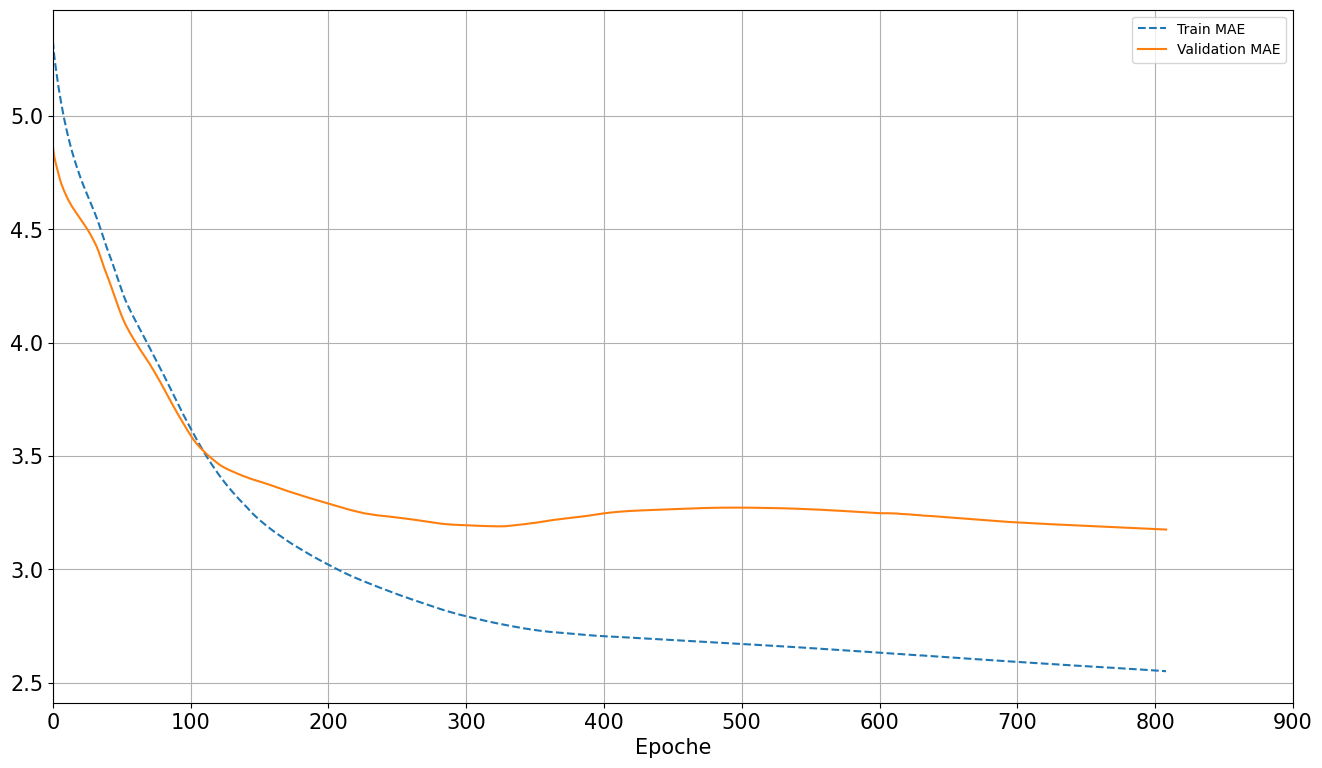

In [14]:
plt.plot(history.history['mae'], label='Train MAE', linestyle='--')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='-')
plt.xlabel('Epoche', fontsize=15)

plt.xlim([0, 900])

plt.legend()
plt.grid(True)
plt.tick_params(axis='both', labelsize=15)
plt.show()

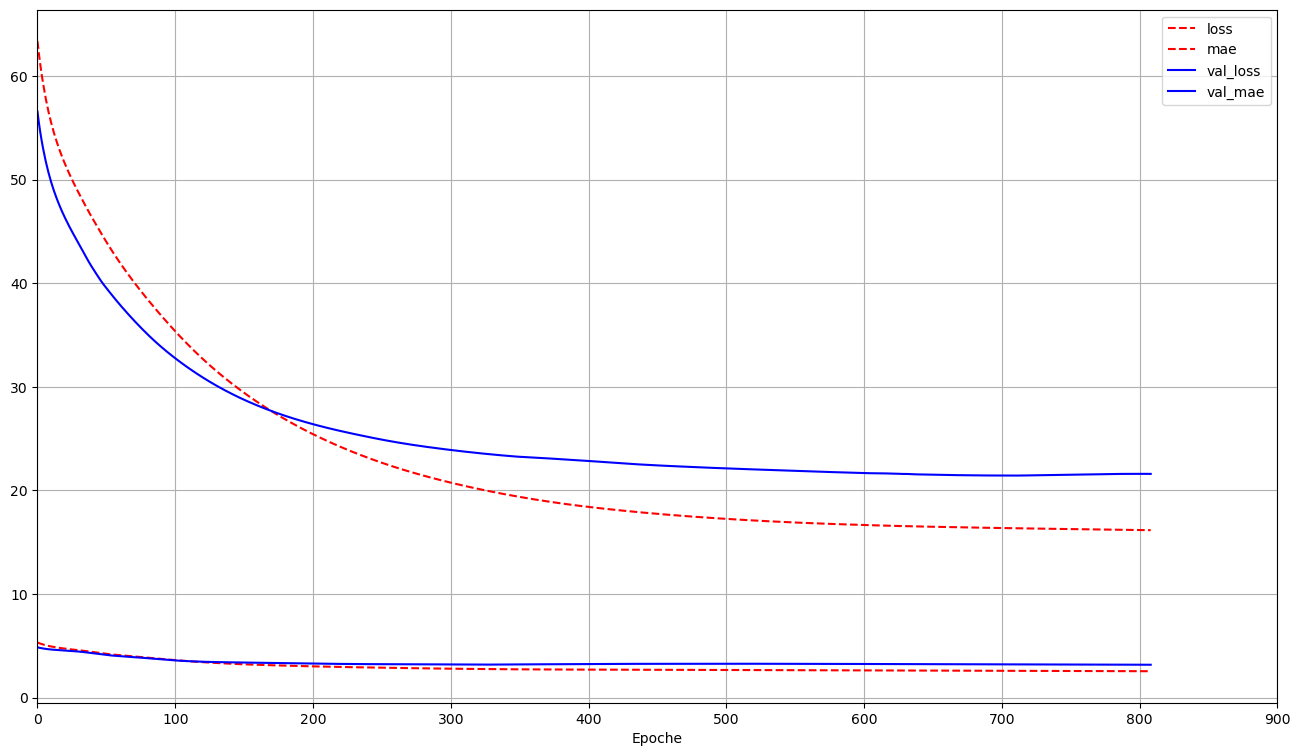

In [15]:
pd.DataFrame(history.history).plot(xlim=[0, 900], grid=True, xlabel="Epoche", style=["r--", "r--", "b-", "b-"])
plt.show()

In [16]:
input_windows_test=[]
target1_windows_test=[]
target7_windows_test=[]
predictions1_test=[]
predictions7_test=[]
mae_test1 = np.zeros((96, 1))
mae_test7 = np.zeros((96, 7))

input_windows_anomaly=[]
target1_windows_anomaly=[]
target7_windows_anomaly=[]
predictions1_anomaly=[]
predictions7_anomaly=[]
mae_anomaly1 = np.zeros((432, 1))
mae_anomaly7 = np.zeros((432, 7))

for batch in test_ds:
    for i in range(32):
        input_windows_test.append((batch[0][i].numpy()))
        target1_windows_test.append((batch[1][i].numpy()))

n_batch=1
for batch in anomaly_ds:
    if(n_batch==11):
        for i in range(7):
            input_windows_anomaly.append((batch[0][i].numpy()))
            target1_windows_anomaly.append((batch[1][i].numpy()))
    else:
         for i in range(32):
            input_windows_anomaly.append((batch[0][i].numpy()))
            target1_windows_anomaly.append((batch[1][i].numpy()))
    n_batch+=1
    
for i in target1_windows_test:
    index=dataset[dataset==i].index[0]
    result = dataset[index:index + pd.Timedelta(days=6)]
    target7_windows_test.append(result.values)

for i in target1_windows_anomaly:
    index=dataset[dataset==i].index[0]
    result = dataset[index:index + pd.Timedelta(days=6)]
    target7_windows_anomaly.append(result.values) 
        
#tolgo le finestre di input che avrebbero finestre target incomplete (che non hanno 7 elementi)
input_windows_anomaly=input_windows_anomaly[:-6]
target7_windows_anomaly=target7_windows_anomaly[:-6]

for i in range(len(input_windows_test)):
    input_window=input_windows_test[i][np.newaxis,:, np.newaxis]
    for step in range(7):
        pred_one_step=model4.predict(input_window, verbose=0)
        input_window=np.concatenate([input_window, pred_one_step.reshape(1,1,1)], axis=1)
    predictions7_test.append(input_window[0, 30:37, 0])
predictions7_test=np.array(predictions7_test)

for i in range(len(input_windows_anomaly)):
    input_window=input_windows_anomaly[i][np.newaxis,:, np.newaxis]
    for step in range(7):
        pred_one_step=model4.predict(input_window, verbose=0)
        input_window=np.concatenate([input_window, pred_one_step.reshape(1,1,1)], axis=1)
    predictions7_anomaly.append(input_window[0, 30:37, 0])
predictions7_anomaly=np.array(predictions7_anomaly)

predictions1_test=predictions7_test[:,0]
predictions1_anomaly=predictions7_anomaly[:,0]

for i in range(len(input_windows_test)):
    mae_test1[i]=abs(predictions1_test[i]-target1_windows_test[i])
        
for i in range(len(input_windows_anomaly)):
    mae_anomaly1[i]=abs(predictions1_anomaly[i]-target1_windows_anomaly[i])

for i in range(len(input_windows_test)):
    for k in range(7):
        mae_test7[i][k]=abs(predictions7_test[i][k]-target7_windows_test[i][k])
        
for i in range(len(input_windows_anomaly)):
    for k in range(7):
        mae_anomaly7[i][k]=abs(predictions7_anomaly[i][k]-target7_windows_anomaly[i][k])

#da capire se fare questa cosa!!!
#mae_test7[30][1:7]=1
#mae_test7[59][1:7]=1
mean_mae_error_test7=pd.Series(np.mean(mae_test7, axis=1))
mean_mae_error_anomaly7=pd.Series(np.mean(mae_anomaly7, axis=1))

#test
#print(mae_test1.mean(), model4.evaluate(test_ds))
#print(mae_test7[:, 0].mean(), model4.evaluate(test_ds))
#print(mae_anomaly1.mean(), model4.evaluate(anomaly_ds))
#print(mae_anomaly7[:, 0].mean(), model4.evaluate(anomaly_ds))

In [18]:
#test_mae, mae_test1.mean()

In [19]:
#mean_mae_error_test7.min(), mean_mae_error_test7.max(), mean_mae_error_test7.mean(), mean_mae_error_test7.std()

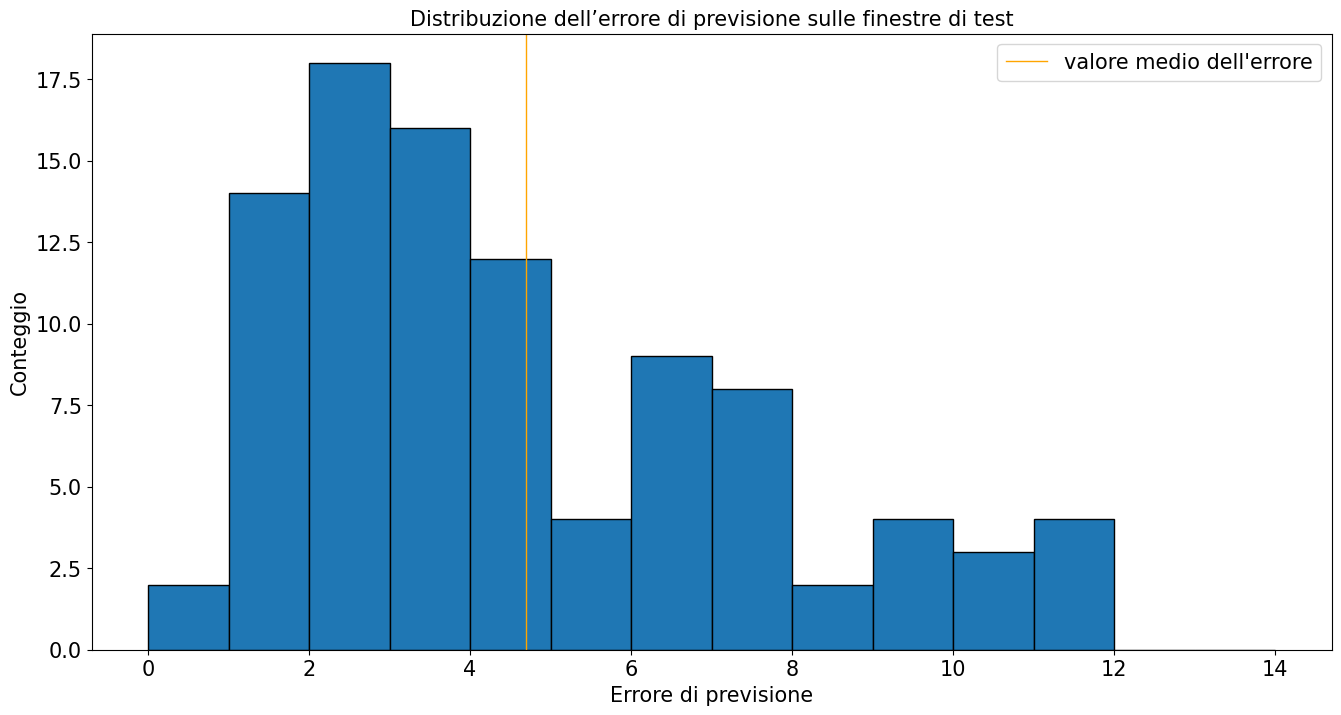

In [20]:
bins=range(0, 15)

mean_mae_error_test7[mean_mae_error_test7>13]=2

plt.hist(mean_mae_error_test7, bins=bins, edgecolor='black') 
plt.title('Distribuzione dell’errore di previsione sulle finestre di test', fontsize=15)
plt.xlabel('Errore di previsione', fontsize=15)
plt.ylabel('Conteggio', fontsize=15)

plt.axvline(mean_mae_error_test7.mean(), color='orange', label='valore medio dell\'errore', linewidth=1)

plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.show()

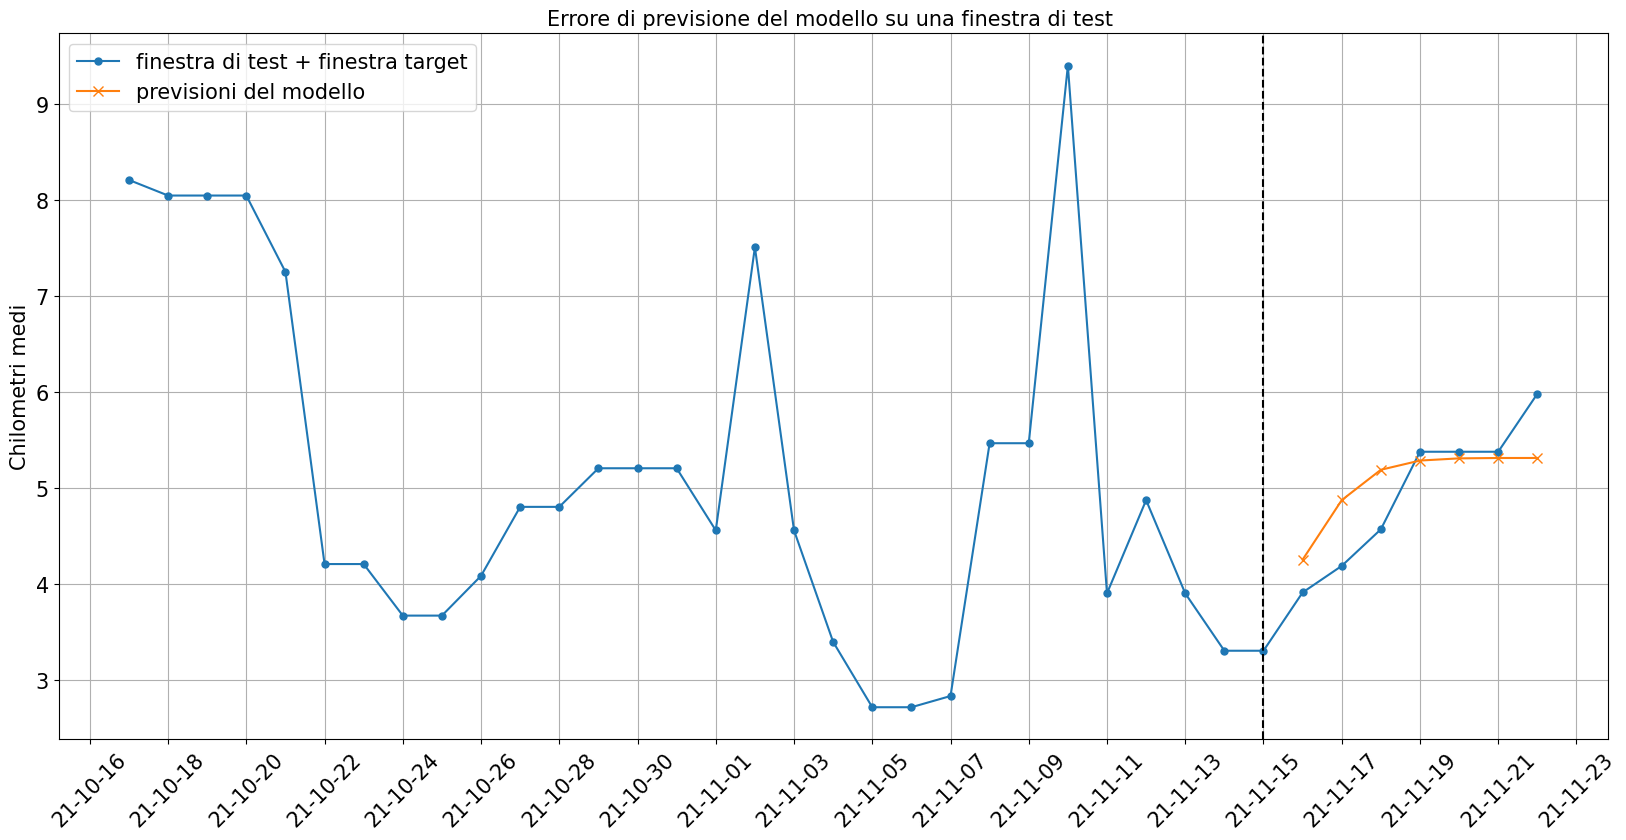


   ERRORE DI PREVISIONE: 0.3631668668115749


In [21]:
#finestre di test
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"]=16,8

for i in range(28,29):
    index=dataset[dataset==input_windows_test[i][0]].index[0]
    input_window=dataset[index:index + pd.Timedelta(days=29)] 
    
    index=dataset[dataset==target7_windows_test[i][0]].index[0]
    target7_windows = dataset[index:index + pd.Timedelta(days=6)]
    
    window37 = pd.concat([input_window, target7_windows])
    dates=window37.index
    values=window37.values
    
    plt.plot_date(dates, values,linestyle='solid', markersize=5, label="finestra di test + finestra target")
    
    prediction7=pd.Series(predictions7_test[i], index=target7_windows.index)
    dates=prediction7.index
    values=prediction7.values
    
    plt.plot_date(dates, values,linestyle='solid', fmt="x", markersize=7, label="previsioni del modello")
    
    #today
    plt.axvline(x=input_window.index[-1], color='black', linestyle='--')
    
    date_formatter = mdates.DateFormatter('%y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_formatter)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.legend(fontsize=15)
    plt.grid(True)    
    plt.tight_layout()
    
    plt.ylabel('Chilometri medi', fontsize=15)
    
    plt.title('Errore di previsione del modello su una finestra di test ', fontsize=15)

    
    plt.tick_params(axis='both', labelsize=15)
    
    plt.show()
    
    print()
    print("   ERRORE DI PREVISIONE:", mean_mae_error_test7[i])   


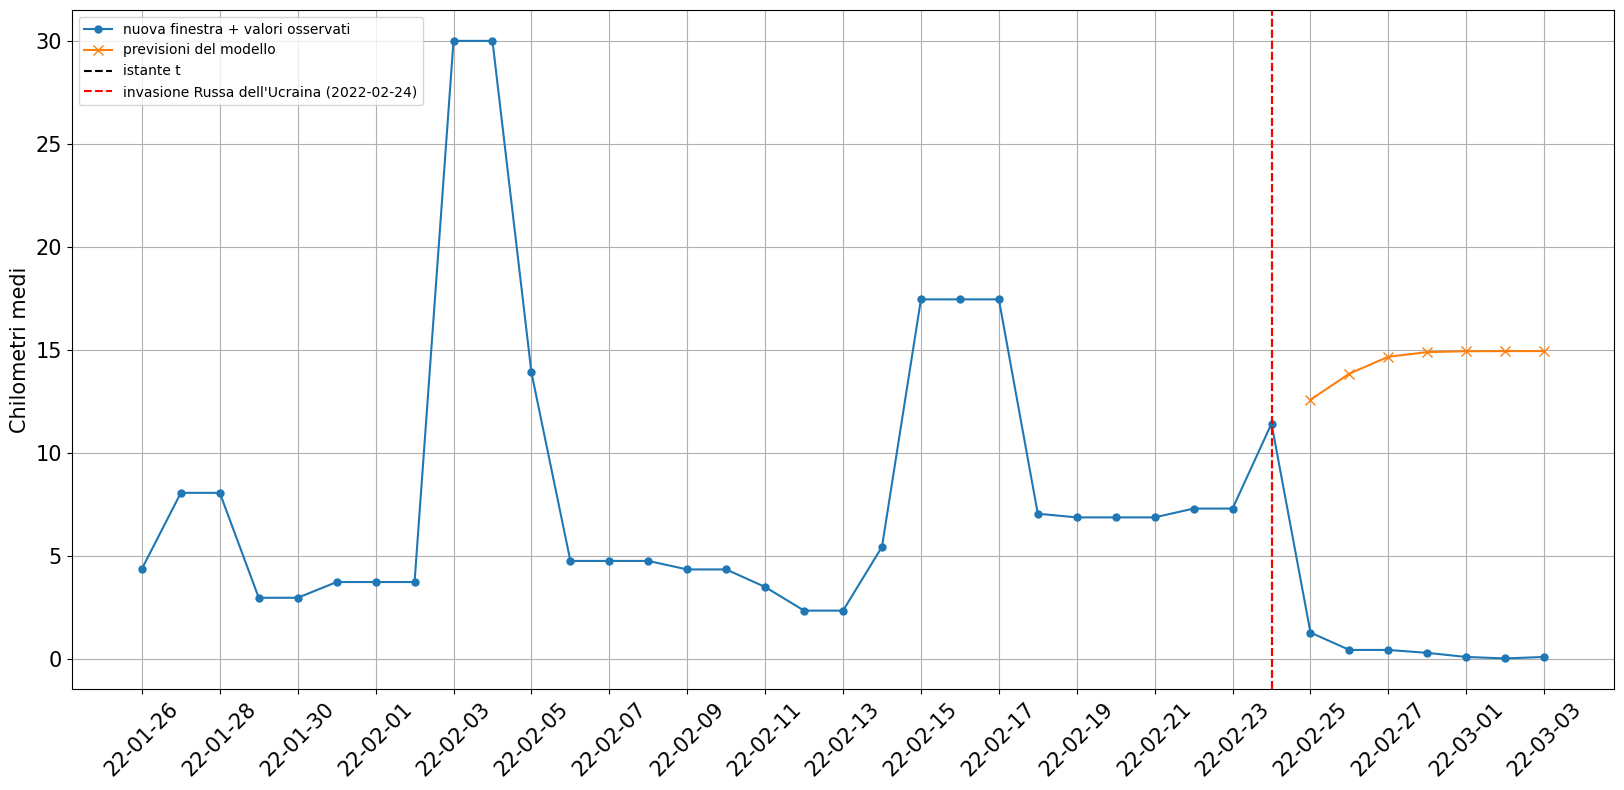

   ERRORE DI PREVISIONE: 14.014913134841839


In [22]:
#inferenza su anomalia!!

import matplotlib.dates as mdates
plt.rcParams["figure.figsize"]=16,8

for i in range(17,18):
    index=dataset[dataset==input_windows_anomaly[i][0]].index[0]
    input_window=dataset[index:index + pd.Timedelta(days=29)] 
    
    index=dataset[dataset==target7_windows_anomaly[i][0]].index[0]
    target7_windows = dataset[index:index + pd.Timedelta(days=6)]
    
    window37 = pd.concat([input_window, target7_windows])
    dates=window37.index
    values=window37.values
    
    plt.plot_date(dates, values,linestyle='solid', markersize=5, label="nuova finestra + valori osservati")
    
    prediction7=pd.Series(predictions7_anomaly[i], index=target7_windows.index)
    dates=prediction7.index
    values=prediction7.values
    
    plt.plot_date(dates, values,linestyle='solid', fmt="x", markersize=7, label="previsioni del modello")
    
    #prediction1=pd.Series(predictions1_anomaly[i:i+7], index=target7_windows.index)
    #dates=prediction1.index
    #values=prediction1.values
    #plt.plot_date(dates, values,linestyle='solid', fmt="x", markersize=7, label="predizioni 1")
    
    #today
    plt.axvline(x=input_window.index[-1], color='black', linestyle='--', label="istante t")

    #russian invasion of ukraine
    plt.axvline(x=datetime(2022, 2, 24), color='r', linestyle='--', label="invasione Russa dell'Ucraina (2022-02-24)")
    
    date_formatter = mdates.DateFormatter('%y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_formatter)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45, fontsize=15)
    
    plt.legend(fontsize=10)
    plt.grid(True)    
    plt.tight_layout()
    
    plt.ylabel('Chilometri medi', fontsize=15)
    
    plt.tick_params(axis='both', labelsize=15)

    plt.show()
   

    print("   ERRORE DI PREVISIONE:", mean_mae_error_anomaly7[i])   